In [ ]:
# Import the 'drive' module from Google Colab to access Google Drive
from google.colab import drive

# Mount Google Drive to the Colab environment at the specified path
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Copy the dataset ZIP file from Google Drive to the local environment
!cp "/content/drive/My Drive/FYP_Project/CBIS_DDSM.zip" .
# Unzip the dataset quietly (suppress output)
!unzip -qq CBIS_DDSM.zip
# Remove the ZIP file after extraction to save storage space
!rm CBIS_DDSM.zip
# Set the dataset directory path
cbis_path = 'CBIS_DDSM'


In [ ]:
# Install TensorFlow
!pip install tensorflow -qq
!pip install pydot graphviz -qq


In [ ]:
# Import all necessary Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model



In [ ]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> benign mass
        1 -> malignant mass
        2 -> benign calcification
        3 -> malignant calcification

    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [ ]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);


Train size: 2676 	 Test size: 336
Image size: 150x150


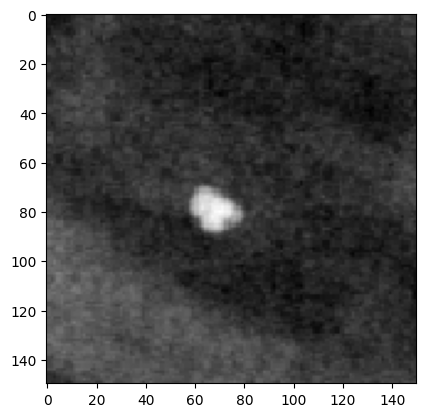

Label: [0. 0. 1. 0.]


In [ ]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

In [ ]:
def create_vgg16(verbose=False, fc_size=256, dropout=None):
    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(150, 150, 3))

    # Freeze the convolutional base before adding it
    vgg16_base.trainable = False

    model = models.Sequential()
    model.add(Input(shape=(150, 150, 3)))
    model.add(vgg16_base)
    model.add(layers.Flatten())

    if dropout is not None:
        model.add(layers.Dropout(dropout))

    model.add(layers.Dense(fc_size, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    if verbose:
        vgg16_base.summary()
        model.summary()

    return model


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,124 (64.14 MB)

 Trainable params: 2,098,436 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

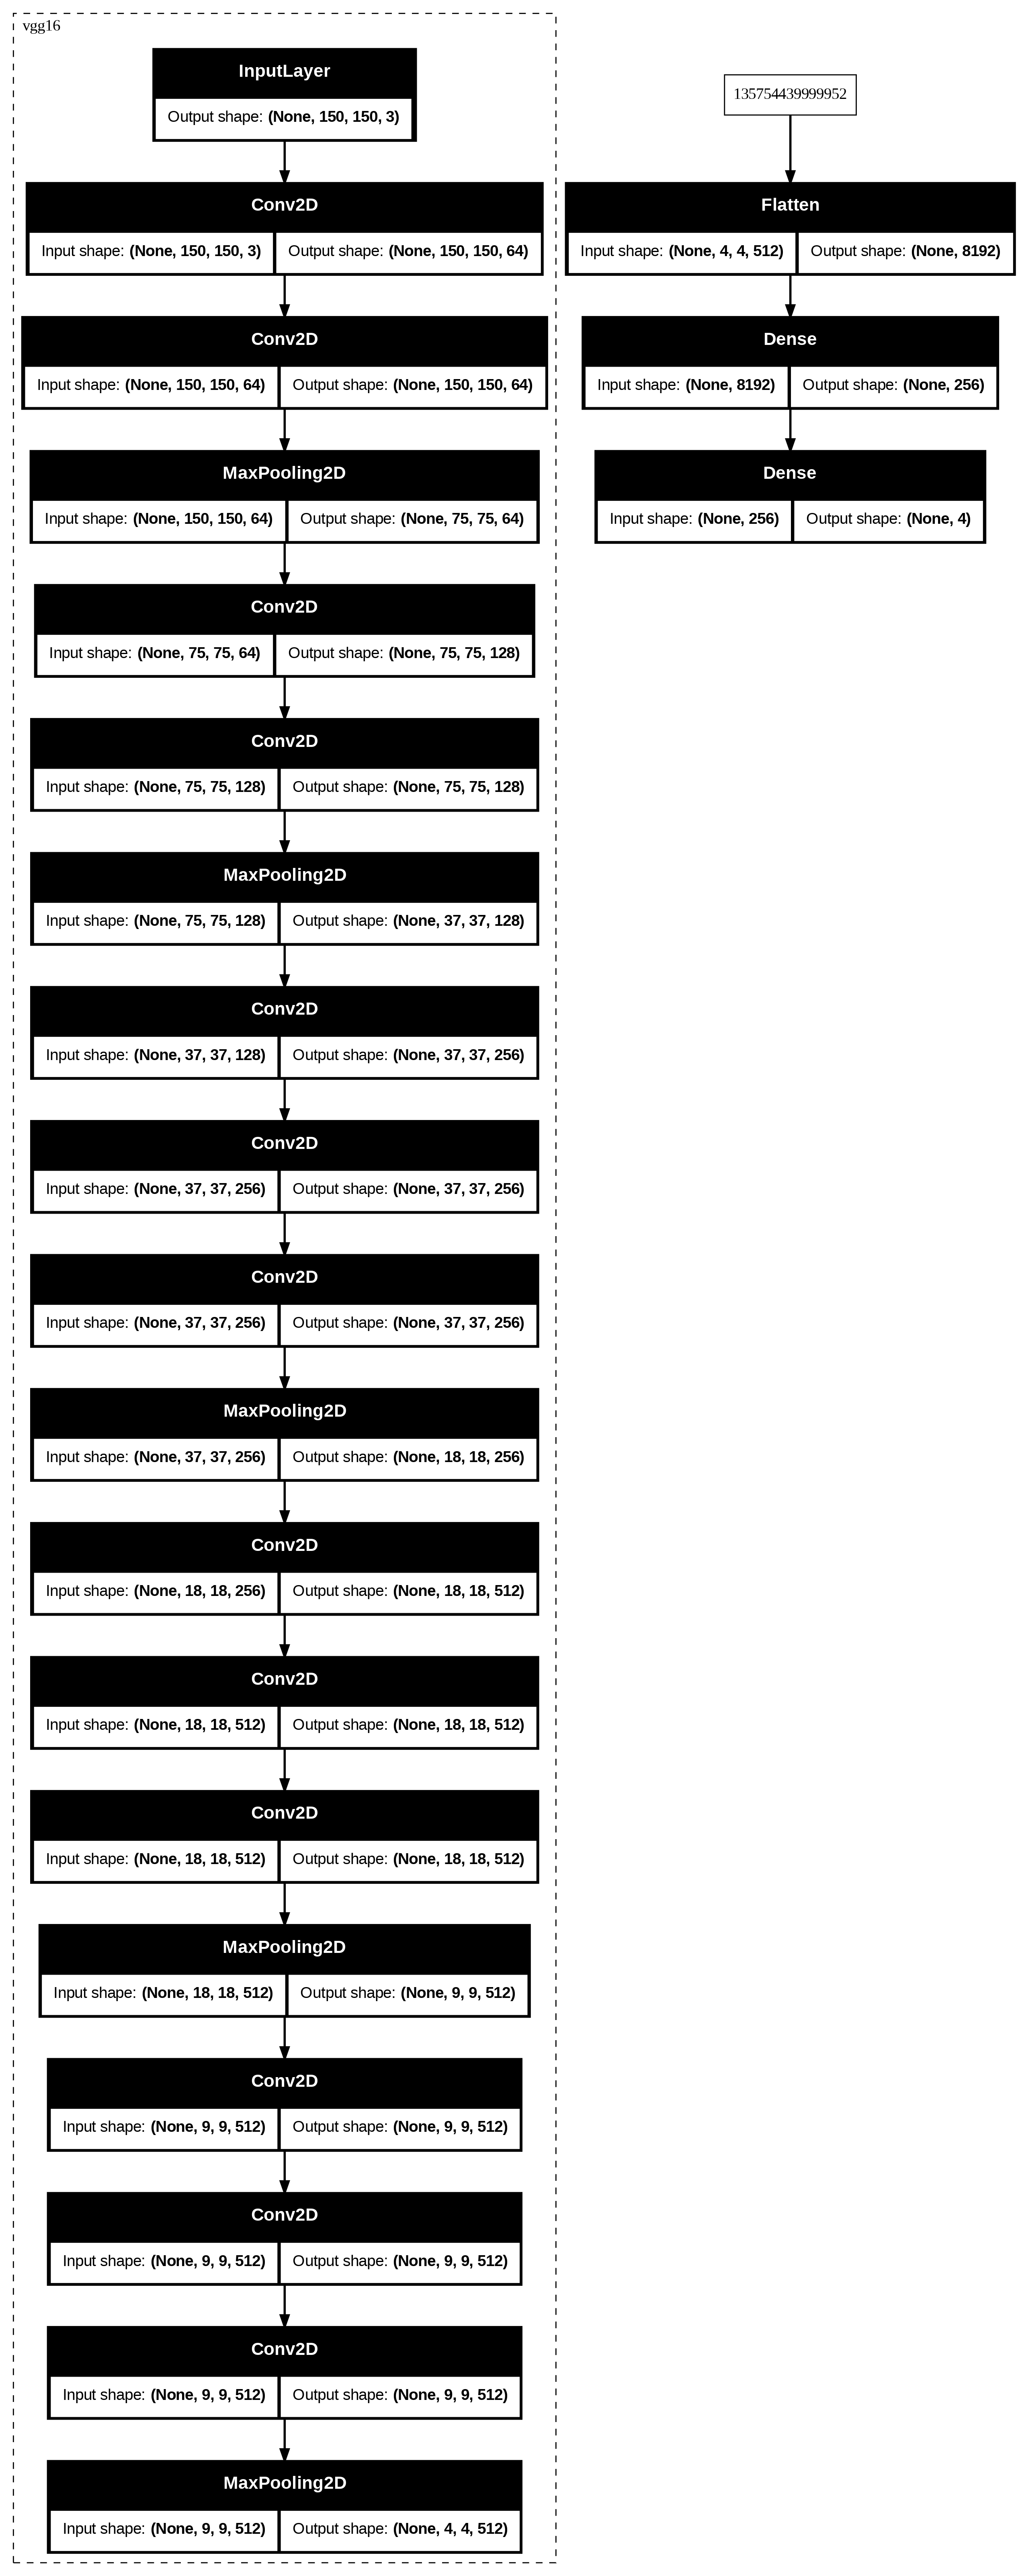

In [ ]:
vgg16_example = create_vgg16(verbose=True)
plot_model(vgg16_example,
           to_file='vgg16_4class.png',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB',
           expand_nested=True)

In [ ]:
# Instantiate model
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

# Early stopping callback
earlystopping = EarlyStopping(
    monitor='val_loss', mode='min', patience=30, verbose=1
)

# Checkpoint callback
checkpoint = ModelCheckpoint(
    'vgg16_fe_drop_128_4cl_best.keras',  # modern extension
    monitor='val_loss', mode='min', verbose=1,
    save_best_only=True, save_freq='epoch'
)

# Compile model
vgg16_fe_drop_128.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
import math

steps_per_epoch = math.ceil(0.8 * n_train_img / 128)
validation_steps = math.ceil(0.2 * n_train_img / 128)

history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, earlystopping],
    verbose=1,
    initial_epoch=0
)

# Save final model
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.keras')  # updated format
!cp vgg16_fe* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.3621 - loss: 5.6706
Epoch 1: val_loss improved from inf to 1.13089, saving model to vgg16_fe_drop_128_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 879ms/step - accuracy: 0.3645 - loss: 5.5349 - val_accuracy: 0.5047 - val_loss: 1.1309
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.4409 - loss: 1.2793
Epoch 2: val_loss improved from 1.13089 to 1.07587, saving model to vgg16_fe_drop_128_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 767ms/step - accuracy: 0.4420 - loss: 1.2760 - val_accuracy: 0.5271 - val_loss: 1.0759
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.4956 - loss: 1.1670
Epoch 3: val_loss improved from 1.07587 to 1.01911, saving model to vgg16_fe_drop_128_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 760ms/step - accuracy: 0.4959 - loss: 1.1650 - val_accuracy: 0.5533 - val_loss: 1.0191
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.5279 - loss: 1.0683

In [ ]:
!cp vgg16_fe* "/content/drive/My Drive/FYP_Project/models/"

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when validation loss was minimized
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Loss and accuracy on test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.keras')  # update if you used .keras

test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

# Print summary
print("\nVGG16 (w/ dropout, smaller FC) Feature Extraction\n")
print("Epoch [end]:            %d" % end_epoch_fe)
print("Epoch [opt]:            %d" % opt_epoch_fe)
print("Valid accuracy [end]:   %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]:   %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:    %.4f" % test_acc_fe)
print("Test accuracy [opt]:    %.4f" % opt_test_acc_fe)
print("Valid loss [end]:       %.4f" % end_val_loss_fe)
print("Valid loss [opt]:       %.4f" % opt_val_loss_fe)
print("Test loss [end]:        %.4f" % test_loss_fe)
print("Test loss [opt]:        %.4f" % opt_test_loss_fe)



VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]:            103
Epoch [opt]:            73
Valid accuracy [end]:   0.6112
Valid accuracy [opt]:   0.6243
Test accuracy [end]:    0.5923
Test accuracy [opt]:    0.5595
Valid loss [end]:       0.9518
Valid loss [opt]:       0.8797
Test loss [end]:        0.9737
Test loss [opt]:        0.9880


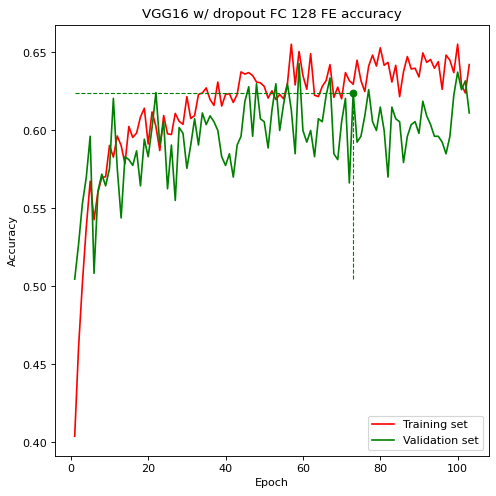

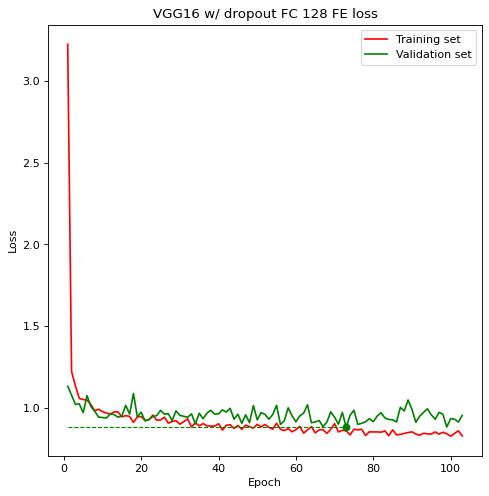

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Instantiate model
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256)

# Callbacks
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)
checkpoint = ModelCheckpoint(
    'vgg16_fe_drop_256_4cl_best.keras',
    monitor='val_loss', mode='min', verbose=1,
    save_best_only=True, save_freq='epoch'
)

# Compile
vgg16_fe_drop_256.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Calculate steps per epoch & validation steps properly
steps_per_epoch = math.ceil(0.8 * n_train_img / 128)
validation_steps = math.ceil(0.2 * n_train_img / 128)

# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, earlystopping],
    shuffle=True,
    verbose=1,
    initial_epoch=0
)

# Save final model
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.keras')

# Copy all models starting with 'vgg16_fe_drop' (change pattern if needed)
!cp vgg16_fe* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.3710 - loss: 7.5870
Epoch 1: val_loss improved from inf to 1.06569, saving model to vgg16_fe_drop_256_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 934ms/step - accuracy: 0.3740 - loss: 7.4015 - val_accuracy: 0.5364 - val_loss: 1.0657
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.5175 - loss: 1.1892
Epoch 2: val_loss improved from 1.06569 to 1.05734, saving model to vgg16_fe_drop_256_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 769ms/step - accuracy: 0.5168 - loss: 1.1885 - val_accuracy: 0.5551 - val_loss: 1.0573
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.5009 - loss: 1.1466
Epoch 3: val_loss improved from 1.05734 to 0.99500, saving model to vgg16_fe_drop_256_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 779ms/step - accuracy: 0.5020 - loss: 1.1458 - val_accuracy: 0.5589 - val_loss: 0.9950
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.5198 - loss: 1.1021

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Epoch range and optimal epoch
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Validation set metrics
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Load best model and evaluate
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.keras')  # update extension if needed
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

# Print summary
print("\nVGG16 (w/ dropout) Feature Extraction\n")
print("Epoch [end]:            %d" % end_epoch_fe)
print("Epoch [opt]:            %d" % opt_epoch_fe)
print("Valid accuracy [end]:   %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]:   %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:    %.4f" % test_acc_fe)
print("Test accuracy [opt]:    %.4f" % opt_test_acc_fe)
print("Valid loss [end]:       %.4f" % end_val_loss_fe)
print("Valid loss [opt]:       %.4f" % opt_val_loss_fe)
print("Test loss [end]:        %.4f" % test_loss_fe)
print("Test loss [opt]:        %.4f" % opt_test_loss_fe)



VGG16 (w/ dropout) Feature Extraction

Epoch [end]:            62
Epoch [opt]:            32
Valid accuracy [end]:   0.6243
Valid accuracy [opt]:   0.6280
Test accuracy [end]:    0.5774
Test accuracy [opt]:    0.5536
Valid loss [end]:       0.9067
Valid loss [opt]:       0.8943
Test loss [end]:        1.0062
Test loss [opt]:        1.0146


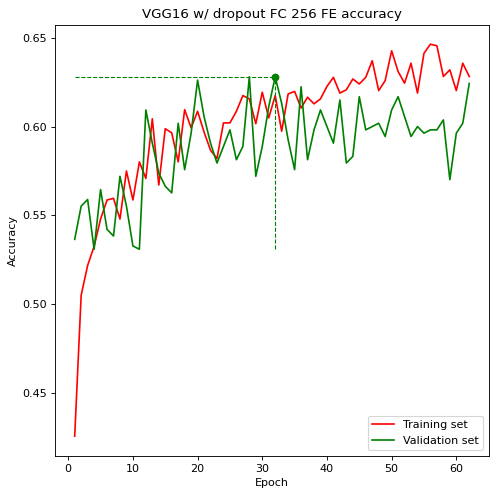

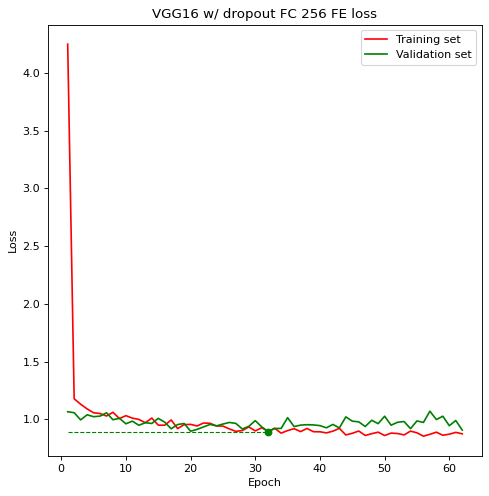

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 256 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 256 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Copy and load pretrained feature extraction model
!cp "/content/drive/My Drive/FYP_Project/models/vgg16_fe_drop_128_4cl_best.keras" .
vgg16_ft_1layer = load_model('vgg16_fe_drop_128_4cl_best.keras')

# Freeze all VGG16 layers
vgg16_base = vgg16_ft_1layer.get_layer('vgg16')
for layer in vgg16_base.layers:
    layer.trainable = False

# Unfreeze only block5_conv3
vgg16_base.get_layer('block5_conv3').trainable = True

# Recompile with a lower learning rate
vgg16_ft_1layer.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summaries
vgg16_ft_1layer.summary()
vgg16_base.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 3,409,028 (13.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
    'vgg16_ft_1layer_4cl_best.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True,
    save_freq='epoch'
)

# Calculate steps per epoch & validation steps properly
steps_per_epoch = math.ceil(0.8 * n_train_img / 128)


# Train (using .fit instead of .fit_generator)
history_ft = vgg16_ft_1layer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint],
    shuffle=True,
    verbose=1,
    initial_epoch=0
)

# Save final model
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.keras')

# Copy models to drive
!cp vgg16_ft* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.6416 - loss: 0.8296
Epoch 1: val_loss improved from inf to 0.93115, saving model to vgg16_ft_1layer_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 874ms/step - accuracy: 0.6422 - loss: 0.8290 - val_accuracy: 0.6243 - val_loss: 0.9311
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.6417 - loss: 0.8254
Epoch 2: val_loss improved from 0.93115 to 0.85904, saving model to vgg16_ft_1layer_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 769ms/step - accuracy: 0.6415 - loss: 0.8259 - val_accuracy: 0.6430 - val_loss: 0.8590
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.6506 - loss: 0.8356
Epoch 3: val_loss did not improve from 0.85904
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 759ms/step - accuracy: 0.6507 - loss: 0.8345 - val_accuracy: 0.6019 - val_loss: 0.9327
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.6702 - loss: 0.7801
Epoch 4: val_loss did not improve from 0.85904
17/17 ━━━━

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']         # updated key
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']     # updated key

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe) + 1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe - 1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe - 1]

# Load best model and evaluate on test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.keras')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)


VGG16 Fine Tuning

Epoch [end]: 81
Epoch [opt]: 51
Valid accuracy [end]: 0.6449
Valid accuracy [opt]: 0.6935
Test accuracy [end]:  0.5714
Test accuracy [opt]:  0.5685
Valid loss [end]: 0.8739
Valid loss [opt]: 0.8139
Test loss [end]:  1.0028
Test loss [opt]:  0.9492


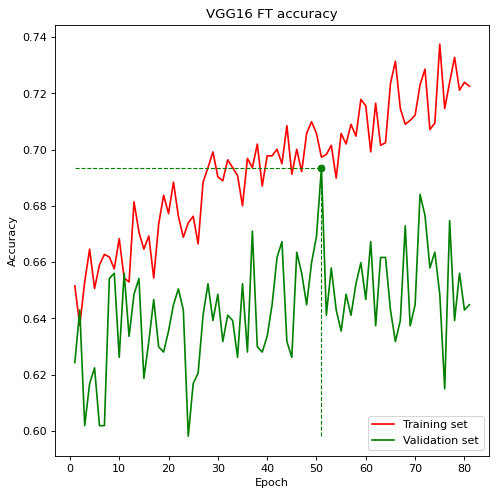

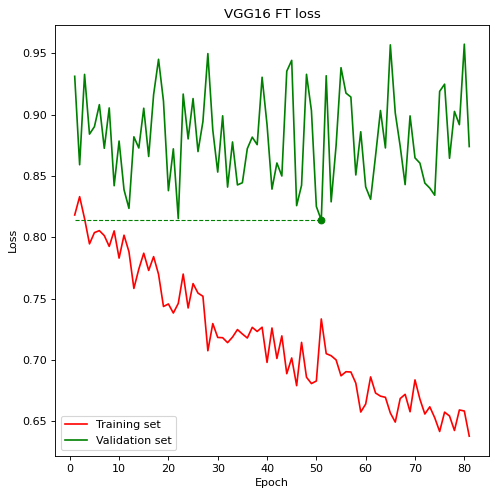

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
!cp "/content/drive/My Drive/FYP_Project/models/vgg16_ft_1layer_4cl_best.keras" .
# Load pretrained model
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.keras')

# Unfreeze last two conv layers only
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile with low learning rate for fine tuning
vgg16_ft_2layer.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 5,768,836 (22.01 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
    'vgg16_ft_2layer_4cl_best.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True,
    save_freq='epoch'
)

# Calculate steps per epoch & validation steps properly
steps_per_epoch = math.ceil(0.8 * n_train_img / 128)

history_ft_2layer = vgg16_ft_2layer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint],
    shuffle=True,
    verbose=1,
    initial_epoch=0
)

models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.keras')
!cp vgg16_ft* "/content/drive/My Drive/FYP_Project/models/"


Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.6163 - loss: 1.1414
Epoch 1: val_loss improved from inf to 0.92204, saving model to vgg16_ft_2layer_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 922ms/step - accuracy: 0.6182 - loss: 1.1306 - val_accuracy: 0.6243 - val_loss: 0.9220
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.6847 - loss: 0.7471
Epoch 2: val_loss did not improve from 0.92204
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 749ms/step - accuracy: 0.6837 - loss: 0.7483 - val_accuracy: 0.6355 - val_loss: 0.9541
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6523 - loss: 0.8074
Epoch 3: val_loss improved from 0.92204 to 0.87063, saving model to vgg16_ft_2layer_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 775ms/step - accuracy: 0.6534 - loss: 0.8056 - val_accuracy: 0.6617 - val_loss: 0.8706
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6871 - loss: 0.7245
Epoch 4: val_loss improved from 0.87063 to 0.84164, savin

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.keras')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)



VGG16 Fine Tuning (2 layers)

Epoch [end]: 58
Epoch [opt]: 28
Valid accuracy [end]: 0.6673
Valid accuracy [opt]: 0.6822
Test accuracy [end]:  0.6250
Test accuracy [opt]:  0.5982
Valid loss [end]: 0.8593
Valid loss [opt]: 0.8008
Test loss [end]:  0.9174
Test loss [opt]:  0.9183


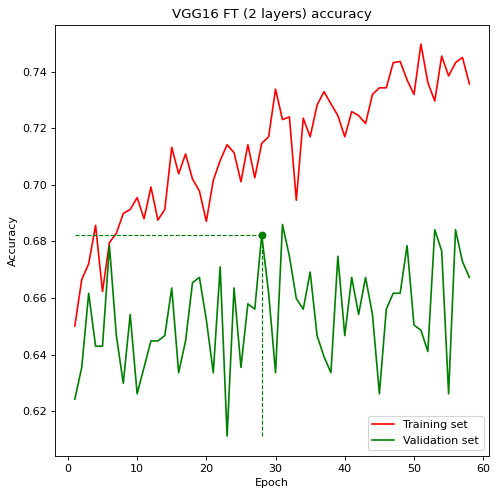

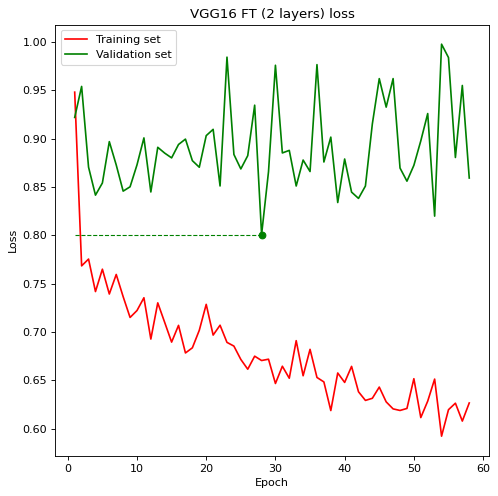

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
!cp "/content/drive/My Drive/FYP_Project/models/vgg16_ft_2layer_4cl_best.keras" .
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.keras')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.keras',
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_freq='epoch')

# Calculate steps per epoch & validation steps properly
steps_per_epoch = math.ceil(0.8 * n_train_img / 128)

# Train
history_ft_3layer = vgg16_ft_3layer.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.keras')
!cp vgg16_ft* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.7460 - loss: 0.6047
Epoch 1: val_loss improved from inf to 0.84821, saving model to vgg16_ft_3layer_4cl_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 913ms/step - accuracy: 0.7452 - loss: 0.6064 - val_accuracy: 0.6766 - val_loss: 0.8482
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.7383 - loss: 0.6170
Epoch 2: val_loss did not improve from 0.84821
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 760ms/step - accuracy: 0.7382 - loss: 0.6168 - val_accuracy: 0.6542 - val_loss: 0.9063
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.7366 - loss: 0.6009
Epoch 3: val_loss did not improve from 0.84821
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 747ms/step - accuracy: 0.7371 - loss: 0.6010 - val_accuracy: 0.6673 - val_loss: 0.9051
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.7626 - loss: 0.5769
Epoch 4: val_loss did not improve from 0.84821
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 741ms/step - accuracy: 0.7615 -

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.keras')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (3 layers)

Epoch [end]: 51
Epoch [opt]: 21
Valid accuracy [end]: 0.7028
Valid accuracy [opt]: 0.6841
Test accuracy [end]:  0.5923
Test accuracy [opt]:  0.6042
Valid loss [end]: 0.8277
Valid loss [opt]: 0.7729
Test loss [end]:  1.0976
Test loss [opt]:  1.0193


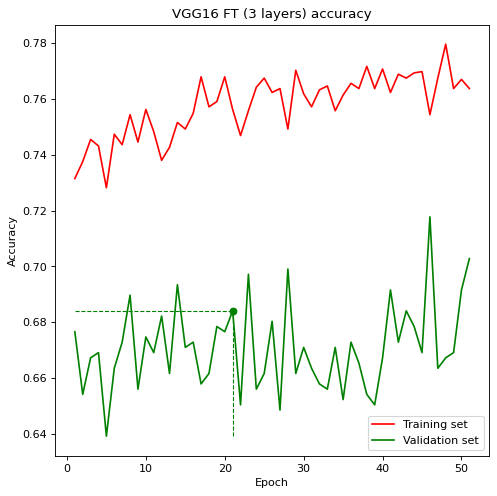

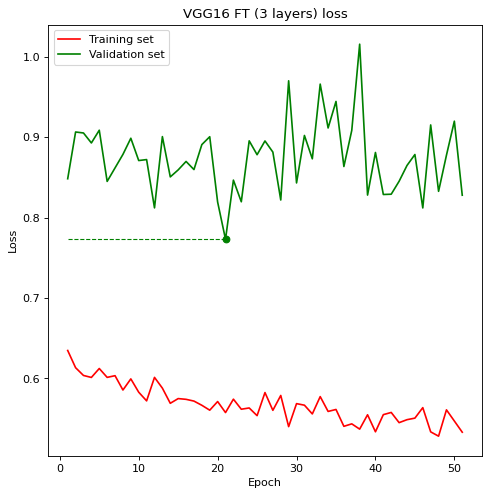

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();